In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

C:\Users\aferraresso\anaconda3\envs\futbol\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\aferraresso\anaconda3\envs\futbol\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\aferraresso\anaconda3\envs\futbol\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Cargamos el dataset y marcamos como tarjet los score "buena"

In [2]:
df = pd.read_csv('data/training_data.csv')
df['es_buena'] = df.score == 'buena'
print(df.shape)

(812, 4)


Dividimos entre train y test, manteniendo la proporcion entre buenas y malas.

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, stratify=df.es_buena)
print(train.shape)
print(test.shape)

(649, 4)
(163, 4)


Por lo visto en el EDA vamos a ignorar algunas palabras muy usadas en el pre-procesamiento, asi que primero objetenemos los terminos mas usados que no son stopwords

In [4]:
from nltk.corpus import stopwords
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], len(words_freq)

freq_words, size = get_top_n_words(train.review)
stopwords_set = [c for c in freq_words if c[0] not in list(stopwords.words('spanish'))][:60]

Instanciamos un NLPCleaner con esas palabras e indicando que haga lematizacion de las palabras. NLPCleaner realiza las siguientes tareas:
- Convierte a minusculas
- Elimina simbolos raros y tildes
- Eliminar stopwords comunes y las especificas que se indican por parametros
- Opcionalmente aplica lematizacion a las palabras.

In [5]:
from nlp_transformer import NLPCleaner,StringFeatures

cleaner = NLPCleaner(stopwords = stopwords_set,
                          with_lemma=True)

100%|█████████████████████████████████████████████████████████████████████| 497560/497560 [00:00<00:00, 1378785.88it/s]


Generamos un Pipeline con el preprocesamiento y el modelo que deseamos entrenar, en este caso LogisticRegression, aunque tambien se probaron BernoulliNB y MultinomialNB. Tambien se evaluo incluir datos como longitud y variedad de terminos, pero no afecto al resultado asi que fueron quitados (es lo que hace la clase StringFeatures)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer


pipe = Pipeline([
    ('clean', cleaner),
#     ('union', FeatureUnion([
        ('tfidf', TfidfVectorizer(max_features=2000, 
                                ngram_range=(1,3))),
#         ('string', StringFeatures())
#     ])),
    ('logistic', LogisticRegression(random_state=0, solver='lbfgs'))
#     ('bernoulli', BernoulliNB()),
#     ('multinomial', MultinomialNB()),
])

Luego entrenamos el modelo con el cojunto train de datos

In [19]:
pipe.fit(train.review,train.es_buena)
print(f'Score: {pipe.score(test.review, test.es_buena)}')

Score: 0.8711656441717791


Y evaluamos diferentes metricas y una matriz de confusión, 

Precision: 0.853
Recall: 0.935
F-Score: 0.892


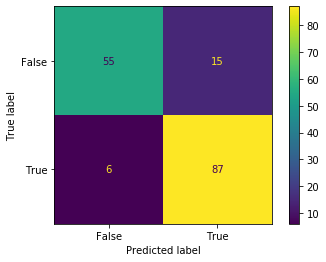

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_hat = pipe.predict(test.review)
print(f'Precision: {precision_score(test.es_buena, y_hat):.{3}f}')
print(f'Recall: {recall_score(test.es_buena, y_hat):.{3}f}')
print(f'F-Score: {f1_score(test.es_buena, y_hat):.{3}f}')
_ = plot_confusion_matrix(pipe, test.review, test.es_buena)

Finalmente, guardamos el pipeline completo para poder utilizarlo desde la app de clasificación

In [21]:
import joblib

joblib.dump(pipe, 'pipe.pkl')

['pipe.pkl']